In [1]:
# Import necessary libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime


ModuleNotFoundError: No module named 'pandas'

In [3]:
def fetch_earthquake_data(datemin='2025-09-15', datemax='2025-10-19', latmax=46,
                        lonmin=123, lonmax=146, latmin=24, magmin=1, fmt='html', nmax=200):
    """
    Fetch earthquake data from GEOFON for Japan region.
    """
    # Base URL
    base_url = 'https://geofon.gfz.de/eqinfo/list.php'
    
    # Build parameters dictionary
    params = {
        'datemin': datemin,
        'datemax': datemax,
        'latmax': latmax,
        'lonmin': lonmin,
        'lonmax': lonmax,
        'latmin': latmin,
        'magmin': magmin,
        'fmt': fmt,
        'nmax': nmax
    }
    
    # Make the request
    print(f"Fetching data from {base_url}...")
    response = requests.get(base_url, params=params)
    response.raise_for_status()  # Raise an error for bad status codes
    
    # Parse HTML with BeautifulSoup
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the earthquake list container
    eqlist = soup.find('div', {'id': 'eqlist'})
    if not eqlist:
        print("No earthquake data found in the response")
        return pd.DataFrame()
    
    earthquakes = []
    
    # Find all earthquake event rows
    # Each earthquake is in a div with class "flex-row row eqinfo-all"
    # Find even and odd rows separately
    evn_event_rows = soup.find_all('div', class_='flex-row row eqinfo-all evnrow')
    odd_event_rows = soup.find_all('div', class_='flex-row row eqinfo-all oddrow')
    
    # Create alternating sequence: first from even, then odd, then even, etc.
    event_rows = []
    max_length = max(len(evn_event_rows), len(odd_event_rows))
    
    for i in range(max_length):
        if i < len(evn_event_rows):
            event_rows.append(evn_event_rows[i])
        if i < len(odd_event_rows):
            event_rows.append(odd_event_rows[i])
    for row in event_rows:
        try:
            # Extract magnitude from the magbox span
            mag_span = row.find('span', class_='magbox')
            if not mag_span:
                continue
            magnitude = float(mag_span.get_text(strip=True))
            
            # Extract region from the strong tag
            region_strong = row.find('strong')
            if not region_strong:
                continue
            region = region_strong.get_text(strip=True)
            
            # Extract coordinates from the title attribute
            region_div = row.find('div', title=True)
            coordinates = region_div.get('title', '') if region_div else ''
            
            # Parse coordinates (format: "127.70°E, 27.17°N")
            latitude = None
            longitude = None
            if coordinates:
                try:
                    # Split by comma and extract lat/lon
                    parts = coordinates.split(', ')
                    if len(parts) == 2:
                        lon_part = parts[0].replace('°E', '').replace('°W', '')
                        lat_part = parts[1].replace('°N', '').replace('°S', '')
                        longitude = float(lon_part)
                        latitude = float(lat_part)
                except (ValueError, IndexError):
                    pass
            
            # Extract time and depth from the second row
            time_depth_row = row.find_all('div', class_='row')[1]
            time_depth_text = time_depth_row.get_text(strip=True)
            
            # Parse time and depth
            # Format: "2025-10-11 14:24:22.4 (≤2 h ago) 86*"
            time_text = ""
            depth_text = ""
            
            # Split by the pull-right span to separate time and depth
            time_span = time_depth_row.find('span', class_='pull-right')
            if time_span:
                # Remove the pull-right span to get time
                time_span.extract()
                time_text = time_depth_row.get_text(strip=True)
                # Clean up time text (remove relative time info)
                time_text = time_text.split('(')[0].strip()
                
                # Extract depth from the removed span
                depth_text = time_span.get_text(strip=True).replace('*', '').strip()
            else:
                # Fallback: try to extract from the full text
                time_text = time_depth_text.split('(')[0].strip()
                # Look for depth pattern
                import re
                depth_match = re.search(r'(\d+)\*?$', time_depth_text)
                if depth_match:
                    depth_text = depth_match.group(1)
            
            # Extract event ID from the parent link
            parent_link = row.find_parent('a')
            event_id = ""
            if parent_link and parent_link.get('href'):
                href = parent_link.get('href')
                # Extract ID from URL like "event.php?id=gfz2025tydw"
                if 'id=' in href:
                    event_id = href.split('id=')[1]
            
            earthquakes.append({
                'Magnitude': magnitude,
                'Region': region,
                'DateTime_UTC': time_text,
                'Depth_km': depth_text if depth_text else None,
                'Latitude': latitude,
                'Longitude': longitude,
                'Event_ID': event_id
            })
            
        except (ValueError, AttributeError, IndexError) as e:
            print(f"Error parsing earthquake data: {e}")
            continue
    
    # Create DataFrame
    df = pd.DataFrame(earthquakes)
    
    print(f"Successfully fetched {len(df)} earthquake records")
    return df


In [2]:
# you can use this function with different parameters to get different data
# df = fetch_earthquake_data(
#     datemin='2025-09-15',
#     datemax='2025-10-19',
#     magmin=5.0  # Only earthquakes with magnitude 5.0 or higher
# )
# you can use this function to get all the data based on the default parameters
df = fetch_earthquake_data()
print("\nEarthquake Data:")
df.head(10)


NameError: name 'fetch_earthquake_data' is not defined

In [6]:
# Save data to CSV file
df.to_csv('JAPAN_GEOFON.csv', index=False, encoding='utf-8')
print("Data saved to 'JAPAN_GEOFON.csv'")

Data saved to 'japan_earthquakes.csv'


In [7]:
# Display basic statistics
print(f"\nTotal earthquakes: {len(df)}")
print(f"\nMagnitude range: {df['Magnitude'].min()} - {df['Magnitude'].max()}")
print(f"\nRegion distribution:")
print(df['Region'].value_counts())

# Display data types and info
print(f"\nDataFrame Info:")
print(df.info())
print(f"\nSample data with all columns:")
# print(df.head())
df.head()



Total earthquakes: 24

Magnitude range: 4.2 - 5.3

Region distribution:
Off East Coast of Honshu, Japan       7
Ryukyu Islands, Japan                 6
Near East Coast of Honshu, Japan      6
Southeast of Honshu, Japan            2
Bonin Islands, Japan Region           1
Southwestern Ryukyu Islands, Japan    1
Eastern Sea of Japan                  1
Name: Region, dtype: int64

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Magnitude     24 non-null     float64
 1   Region        24 non-null     object 
 2   DateTime_UTC  24 non-null     object 
 3   Depth_km      24 non-null     object 
 4   Latitude      24 non-null     float64
 5   Longitude     24 non-null     float64
 6   Event_ID      24 non-null     object 
dtypes: float64(3), object(4)
memory usage: 1.4+ KB
None

Sample data with all columns:


,Magnitude,Region,DateTime_UTC,Depth_km,Latitude,Longitude,Event_ID
0,4.8,"Ryukyu Islands, Japan",2025-10-11 14:24:22.4,86,27.17,127.70,gfz2025tydw
1,4.8,"Southeast of Honshu, Japan",2025-10-11 03:22:02.2,445,30.39,138.44,gfz2025txia
2,5.3,"Ryukyu Islands, Japan",2025-10-07 21:38:38.3,10,29.34,129.10,gfz2025trkf
3,4.8,"Off East Coast of Honshu, Japan",2025-10-07 01:17:17.8,10,37.77,144.19,gfz2025tpvx
4,5.1,"Near East Coast of Honshu, Japan",2025-10-07 00:30:25.0,53,37.58,141.27,gfz2025tpuj


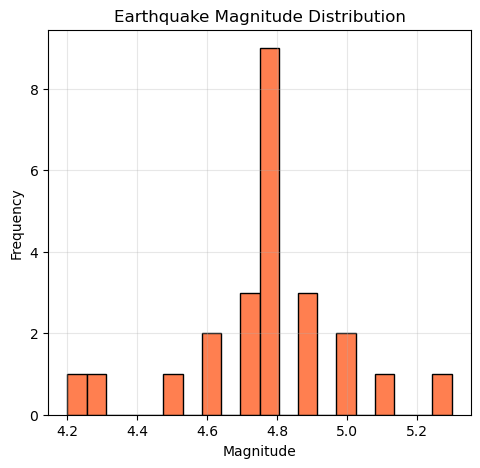

In [9]:
# Optional: Visualize magnitude distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Histogram of magnitudes
plt.subplot(1, 2, 1)
plt.hist(df['Magnitude'], bins=20, color='coral', edgecolor='black')
plt.xlabel('Magnitude')
plt.ylabel('Frequency')
plt.title('Earthquake Magnitude Distribution')
plt.grid(True, alpha=0.3)

# # Bar chart of top regions
# plt.subplot(1, 2, 2)
# region_counts = df['Region'].value_counts().head(10)
# region_counts.plot(kind='barh', color='skyblue')
# plt.xlabel('Number of Earthquakes')
# plt.ylabel('Region')
# plt.title('Top 10 Earthquake Regions')
# plt.tight_layout()
# plt.show()
